In [495]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
# %pip install understatapi
from understatapi import UnderstatClient

YEAR = '2018'
LEAGUE = 'EPL'
# get data for every player playing in the Premier League in 2019/20


In [496]:
def process_shot_data(player_shot_data):
    for shot in player_shot_data:
        shot['ScoredEarlier']=0
        shot['ScoredPenEarlier']=0
        shot['ScoredLater']=0
        shot['ScoredPenLater']=0
        shot['PrevAccumXG']=0.0

        # if shot['a_goals']==shot['h_goals']:
        #     shot['State']='tied'
        # elif (shot['a_goals']>shot['h_goals'] and shot['h_a']=='a') or (shot['a_goals']<shot['h_goals'] and shot['h_a']=='h'):
        #     shot['State']='winning'
        # else:
        #     shot['State']='losing'
        # ovo ne radi jer H_GOALS i A_GOALS prikazuju rezultat na kraju, a ne u trenutku suta.
        
        if(shot['result']=='Goal'):
            shot['IsGoal']=True
        else:
            shot['IsGoal']=False


    for i in range(len(player_shot_data)):
        shot = player_shot_data[i]
        original_date = (shot['date'].split()[0])
        if(shot['result']=='Goal'):
            j=i+1
            while  j<len(player_shot_data) and player_shot_data[j]['date'].split()[0] == original_date:
                player_shot_data[j]['ScoredEarlier']=1
                j+=1
            
            
            j=i-1
            while player_shot_data[j]['date'].split()[0] == original_date and j>=0:
                player_shot_data[j]['ScoredLater']=1
                j-=1

    if(len(player_shot_data)==0): return
    prev_date = 'fake date'
    for i in range(len(player_shot_data)):
        shot = player_shot_data[i]
        if shot['date'].split()[0] != prev_date:
            accum_xG = 0.0
            prev_date = shot['date'].split()[0]
        shot['PrevAccumXG']=accum_xG
        accum_xG+=float(shot['xG'])

        
        # print(shot['date'].split()[0])
        # print(shot['minute'])




In [497]:
def prepare_one_dataframe(YEAR, LEAGUE):
    understat = UnderstatClient()
    league_player_ids = set()
    league_player_data = understat.league(league=LEAGUE).get_player_data(season=YEAR)
    league_player_ids.update( [player['id'] for player in league_player_data])

    all_player_shot_data = []
    for player_id in league_player_ids:
        shot_data = understat.player(player=player_id).get_shot_data()
        process_shot_data(shot_data)
        all_player_shot_data+=shot_data





    from heapq import merge


    match_shots = [understat.match(match_info['id']).get_shot_data() for match_info in understat.league(LEAGUE).get_match_data(season = YEAR)]

    all_match_shot_data = []

    for i in range(len(match_shots)):
        team_dic = match_shots[i]
        match=list(merge(team_dic['a'], team_dic['h'], key=lambda shot : int(shot['minute'])))

        home_goals_so_far=0
        away_goals_so_far=0
        for shot in match:
            if shot['h_a']=='h':
                shot['MyScore']=home_goals_so_far
                shot['OppScore']=away_goals_so_far
            else:
                shot['MyScore']=away_goals_so_far
                shot['OppScore']=home_goals_so_far

            if shot['result']=='Goal':
                if shot['h_a']=='h':
                    home_goals_so_far+=1
                else:
                    away_goals_so_far+=1
        match_shots[i]=match
        all_match_shot_data+=match



    matchshotdf = pd.DataFrame(all_match_shot_data).set_index('id')
    matchshotdf.head(10)
    shotdf = pd.DataFrame(all_player_shot_data)
    shotdf['PrevAccumXG'].head(20)
    #shotdf.to_csv(f'../data/shotdf_without_betting_before_processing_{YEAR}_{LEAGUE}.csv')
    shotdf = shotdf[ shotdf['season'] == YEAR ].set_index('id')

    # print(shotdf.head(10),
    # matchshotdf[['MyScore','OppScore']].head(10))
    matchshotdf = matchshotdf[['MyScore','OppScore']]
    #matchshotdf.to_csv(f'../data/scores_{YEAR}_{LEAGUE}.csv')
    shotdf = shotdf.join(matchshotdf, how='inner')

    # shotdf['minute'] = shotdf['minute'].apply(int)
    # shotdf['xG'] = shotdf['xG'].apply(float)

    shotdf = shotdf[['minute', 'xG','h_a','season','h_team','a_team','player','date','ScoredEarlier','ScoredPenEarlier','ScoredLater','ScoredPenLater','IsGoal','MyScore','OppScore','PrevAccumXG']]

    shotdf.to_csv(f'../data/shotdf_without_betting_{YEAR}_{LEAGUE}.csv')

    #test

    shotdf2 = pd.read_csv(f'../data/shotdf_without_betting_{YEAR}_{LEAGUE}.csv')
    print('starting test:')
    print(shotdf.iloc[1])
    print(shotdf2.iloc[1])
    index1 = shotdf.index
    index2 = shotdf2.index
    print(index1[:10])
    print(index2[:10])
    print(len(index1))
    print(len(index2))
    for elem in shotdf.iloc[1]:
        print(type(elem))
    for elem in shotdf2.iloc[1]:
        print(type(elem))
    print('ending test')



In [498]:
shotdf=None
try:
    shotdf = pd.read_csv(f'../data/shotdf_without_betting_{YEAR}_{LEAGUE}.csv')
except Exception:
    prepare_one_dataframe(YEAR, LEAGUE)
    shotdf = pd.read_csv(f'../data/shotdf_without_betting_{YEAR}_{LEAGUE}.csv')

In [499]:
totalxg=shotdf['xG'].sum()
totalgoals=shotdf['IsGoal'].sum()
print(totalgoals / totalxg)
print(len(shotdf[shotdf['ScoredLater']==1]['IsGoal'].index))
print( shotdf[shotdf['ScoredLater']==1]['IsGoal'].sum() / shotdf[ shotdf['ScoredLater'] == 1]['xG'].sum())

0.942070813980487
931
0.8577719191681842


In [500]:
print(len(shotdf.index))
shotdf = shotdf[shotdf['xG']>0.16]
if LEAGUE!='EPL': raise Exception('xg penala?')
shotdf = shotdf[shotdf['xG']<0.76]
print(len(shotdf.index))
shotdf['ScaledIsGoal'] = shotdf['IsGoal'] / shotdf['xG']
shotdf['ScaledIsGoal'].head(30)

9661
1330


0      1.848853
2      2.024431
14     1.963645
21     1.667578
23     0.000000
30     2.084480
32     2.190230
34     0.000000
49     0.000000
52     2.169301
53     0.000000
59     1.582319
60     1.583955
65     0.000000
68     0.000000
69     0.000000
86     0.000000
89     0.000000
103    0.000000
108    0.000000
161    0.000000
187    4.044473
191    1.975933
195    0.000000
214    0.000000
228    0.000000
232    0.000000
236    0.000000
241    0.000000
249    0.000000
Name: ScaledIsGoal, dtype: float64

In [501]:
shotdf.head()

,id,minute,xG,h_a,season,h_team,a_team,player,date,ScoredEarlier,ScoredPenEarlier,ScoredLater,ScoredPenLater,IsGoal,MyScore,OppScore,PrevAccumXG,ScaledIsGoal
0,232922,16,0.540876,a,2018,Wolverhampton Wanderers,Everton,Richarlison,2018-08-11 19:30:00,0,0,1,0,True,0,0,0.000000,1.848853
2,233068,30,0.493966,h,2018,Everton,Southampton,Richarlison,2018-08-18 17:00:00,0,0,0,0,True,1,0,0.000000,2.024431
14,249039,6,0.509257,a,2018,Leicester,Everton,Richarlison,2018-10-06 14:00:00,0,0,0,0,True,0,0,0.000000,1.963645
21,249845,76,0.599672,h,2018,Everton,Brighton,Richarlison,2018-11-03 15:00:00,1,0,0,0,True,2,1,0.239357,1.667578
23,250347,39,0.355973,h,2018,Everton,Cardiff,Richarlison,2018-11-24 15:00:00,0,0,0,0,False,0,0,0.000000,0.000000


In [502]:

shotdf['IsHome'] = (shotdf['h_a']=='h').apply(int)
shotdf['IsPenalty'] = ((shotdf['xG']>0.761) & (shotdf['xG']<0.7615))
if LEAGUE!='EPL': raise Exception('xg penal')
shotdf['WinProb']=-2.0
shotdf['LoseProb']=-2.0
shotdf['rnd1']=shotdf.index % 3 == 0
shotdf['rnd2']=(shotdf.index % 5 == 0)*3-1
shotdf['ScoreDiff']=shotdf['MyScore']-shotdf['OppScore']
shotdf['ChasingEq'] = (shotdf['ScoreDiff']==-1)
shotdf['ChasingWinner']=(shotdf['ScoreDiff']==0)
shotdf['WastedXG']=shotdf['PrevAccumXG']-1.5*shotdf['ScoredEarlier']
shotdf.loc[shotdf['WastedXG']<0.8, 'WastedXG']=0.0
shotdf['Urgency'] = 90*(shotdf['ChasingEq'] + shotdf['ChasingWinner'])/((120-shotdf['minute']))-1
shotdf['WinningUnderdog'] = 5*(shotdf['LoseProb']-shotdf['WinProb'])+shotdf['ScoreDiff']
shotdf['LosingFavorite']=0.0
shotdf.loc[shotdf['WinningUnderdog']<0, 'LosingFavorite']= -shotdf['WinningUnderdog']
shotdf.loc[shotdf['WinningUnderdog']<0, 'WinningUnderdog']= 0.0

In [503]:
shotdf.head()


,id,minute,xG,h_a,season,h_team,a_team,player,date,ScoredEarlier,...,LoseProb,rnd1,rnd2,ScoreDiff,ChasingEq,ChasingWinner,WastedXG,Urgency,WinningUnderdog,LosingFavorite
0,232922,16,0.540876,a,2018,Wolverhampton Wanderers,Everton,Richarlison,2018-08-11 19:30:00,0,...,-2.0,True,2,0,False,True,0.0,-0.134615,0.0,0.0
2,233068,30,0.493966,h,2018,Everton,Southampton,Richarlison,2018-08-18 17:00:00,0,...,-2.0,False,-1,1,False,False,0.0,-1.000000,1.0,0.0
14,249039,6,0.509257,a,2018,Leicester,Everton,Richarlison,2018-10-06 14:00:00,0,...,-2.0,False,-1,0,False,True,0.0,-0.210526,0.0,0.0
21,249845,76,0.599672,h,2018,Everton,Brighton,Richarlison,2018-11-03 15:00:00,1,...,-2.0,True,-1,1,False,False,0.0,-1.000000,1.0,0.0
23,250347,39,0.355973,h,2018,Everton,Cardiff,Richarlison,2018-11-24 15:00:00,0,...,-2.0,False,-1,0,False,True,0.0,0.111111,0.0,0.0


In [504]:
import json
betting_nameset = set()
def get_season_betting_data(year, league, no_pages=8, translator=None):
    year = int(year)
    betting_nameset = set()
    jsondata=None
    ctr=0
    for i in range(1,no_pages+1):
        with open(f'../data/betting_{year}_{league}_page_{i}.json') as f:
            jsondata = json.load(f)
        print( jsondata['d']['rows'][0].keys() )

        # print( jsondata['d']['rows'][0]['odds'][2] )
        # print( jsondata['d']['rows'][0]['date-start-timestamp'] )
        if translator is None:
            for row in jsondata['d']['rows']:
                betting_nameset.add(row['home-name'])
            return betting_nameset, None
        else:
            
            for row in jsondata['d']['rows']:
                ctr+=1
                mask_home = (shotdf['season'] == year) & (shotdf['h_team'] == translator[row['home-name']]) & (shotdf['a_team'] == translator[row['away-name']]) & (shotdf['IsHome']==True)
                mask_away = (shotdf['season'] == year) & (shotdf['h_team'] == translator[row['home-name']]) & (shotdf['a_team'] == translator[row['away-name']]) & (shotdf['IsHome']==False)
                print(mask_home.sum(), mask_away.sum())
                #print(mask.max())
                if mask_home.max()==0 and mask_away.max()==0:
                    print('LOSE', year, row['home-name'], row['away-name'])
                shotdf.loc[mask_home, 'WinProb'] = 1. / row['odds'][0]['avgOdds'] 
                shotdf.loc[mask_home, 'LoseProb'] = 1. / row['odds'][2]['avgOdds']
                shotdf.loc[mask_away, 'LoseProb'] = 1. / row['odds'][0]['avgOdds'] 
                shotdf.loc[mask_away, 'WinProb'] = 1. / row['odds'][2]['avgOdds']
            print(f'{ctr=}')


#ovaj deo sluzi samo za nameset! kasnije se zap koristi get_season_betting_data

names, _ = get_season_betting_data(2019, LEAGUE)
print(names)
betting_nameset = betting_nameset.union(names)
names, _ = get_season_betting_data(2020, LEAGUE)
betting_nameset = betting_nameset.union(names)
names, _ = get_season_betting_data(2021, LEAGUE)
betting_nameset = betting_nameset.union(names)
# names, _ = get_season_betting_data(2022, LEAGUE)
# betting_nameset = betting_nameset.union(names)


dict_keys(['id', 'is-double', 'superTemplate', 'home', 'away', 'home-name', 'away-name', 'home-country-two-chart-name', 'away-country-two-chart-name', 'home-participant-id', 'away-participant-id', 'status-id', 'event-stage-id', 'event-stage-name', 'event-stage-name-short', 'tournament_id', 'tournament-stage-id', 'tournament-stage-type-id', 'tournament-stage-group-id', 'tournament-stage-name', 'sport-id', 'cols', 'home-participant-images', 'away-participant-images', 'encodeEventId', 'colClassName', 'homeParticipantTypes', 'awayParticipantTypes', 'ftOnly', 'ftOnlyText', 'ftOnlyTextShort', 'url', 'date-start-base', 'date-start-timestamp', 'result', 'homeResult', 'awayResult', 'homeTextInResult', 'awayTextInResult', 'home-winner', 'away-winner', 'postmatchResult', 'info', 'partialresult', 'country-id', 'country-name', 'country-two-chart-name', 'country-type', 'tournament-id', 'tournament-name', 'tournament-url', 'sport-url-name', 'breadcrumbs', 'stream', 'bookmakersCount', 'winner_post', '

In [505]:
understat_nameset = set(shotdf['h_team'].tolist())
# shotdf.apply(axis = 1, func = lambda row : understat_nameset.add(row['h_team']))

print(len(shotdf.index))
print(understat_nameset)
shotdf.head()
# beting_iter = iter(betting_nameset)

1330
{'Crystal Palace', 'Wolverhampton Wanderers', 'Liverpool', 'Everton', 'Watford', 'Tottenham', 'Bournemouth', 'Burnley', 'Leicester', 'Chelsea', 'Manchester City', 'Fulham', 'West Ham', 'Cardiff', 'Arsenal', 'Huddersfield', 'Newcastle United', 'Brighton', 'Southampton', 'Manchester United'}


,id,minute,xG,h_a,season,h_team,a_team,player,date,ScoredEarlier,...,LoseProb,rnd1,rnd2,ScoreDiff,ChasingEq,ChasingWinner,WastedXG,Urgency,WinningUnderdog,LosingFavorite
0,232922,16,0.540876,a,2018,Wolverhampton Wanderers,Everton,Richarlison,2018-08-11 19:30:00,0,...,-2.0,True,2,0,False,True,0.0,-0.134615,0.0,0.0
2,233068,30,0.493966,h,2018,Everton,Southampton,Richarlison,2018-08-18 17:00:00,0,...,-2.0,False,-1,1,False,False,0.0,-1.000000,1.0,0.0
14,249039,6,0.509257,a,2018,Leicester,Everton,Richarlison,2018-10-06 14:00:00,0,...,-2.0,False,-1,0,False,True,0.0,-0.210526,0.0,0.0
21,249845,76,0.599672,h,2018,Everton,Brighton,Richarlison,2018-11-03 15:00:00,1,...,-2.0,True,-1,1,False,False,0.0,-1.000000,1.0,0.0
23,250347,39,0.355973,h,2018,Everton,Cardiff,Richarlison,2018-11-24 15:00:00,0,...,-2.0,False,-1,0,False,True,0.0,0.111111,0.0,0.0


In [506]:
name_translator = {}
l_betting_nameset = list(betting_nameset)
for name in l_betting_nameset:
    if name in understat_nameset:
        name_translator[name]=name
        understat_nameset.remove(name)
        betting_nameset.remove(name)
print(betting_nameset)
name_translator['Manchester Utd'] = 'Manchester United'
name_translator['Wolves'] = 'Wolverhampton Wanderers'
name_translator['Newcastle'] = 'Newcastle United'
name_translator['Sheffield Utd'] = 'Sheffield United'
name_translator['Nottingham'] = 'Nottingham Forest'
name_translator['Brentford'] = 'Brentford'
name_translator['Fulham'] = 'Fulham'
name_translator['Leeds'] = 'Leeds'
name_translator['West Brom'] = 'West Bromwich Albion'
name_translator['Luton']='Luton'
name_translator['Huddersfield']='Huddersfield'
name_translator['Cardiff']='Cardiff'

{'Brentford', 'Wolves', 'Sheffield Utd', 'West Brom', 'Leeds', 'Aston Villa', 'Newcastle', 'Manchester Utd', 'Norwich'}


In [507]:
print(YEAR)
print(type(YEAR))

2018
<class 'str'>


In [508]:
betting_data = get_season_betting_data(YEAR, LEAGUE, 8, name_translator)

dict_keys(['id', 'is-double', 'superTemplate', 'home', 'away', 'home-name', 'away-name', 'home-country-two-chart-name', 'away-country-two-chart-name', 'home-participant-id', 'away-participant-id', 'status-id', 'event-stage-id', 'event-stage-name', 'event-stage-name-short', 'tournament_id', 'tournament-stage-id', 'tournament-stage-type-id', 'tournament-stage-group-id', 'tournament-stage-name', 'sport-id', 'cols', 'home-participant-images', 'away-participant-images', 'encodeEventId', 'colClassName', 'homeParticipantTypes', 'awayParticipantTypes', 'ftOnly', 'ftOnlyText', 'ftOnlyTextShort', 'url', 'date-start-base', 'date-start-timestamp', 'result', 'homeResult', 'awayResult', 'homeTextInResult', 'awayTextInResult', 'home-winner', 'away-winner', 'postmatchResult', 'info', 'partialresult', 'country-id', 'country-name', 'country-two-chart-name', 'country-type', 'tournament-id', 'tournament-name', 'tournament-url', 'sport-url-name', 'breadcrumbs', 'stream', 'bookmakersCount', 'betting_type', 

6 0
0 0
LOSE 2018 Manchester Utd Manchester City
1 1
0 0
LOSE 2018 Tottenham Brighton
2 4
1 1
2 4
1 2
2 0
1 2
5 3
1 1
2 1
3 0
2 2
0 1
1 2
1 2
0 4
1 2
0 4
ctr=50
dict_keys(['id', 'is-double', 'superTemplate', 'home', 'away', 'home-name', 'away-name', 'home-country-two-chart-name', 'away-country-two-chart-name', 'home-participant-id', 'away-participant-id', 'status-id', 'event-stage-id', 'event-stage-name', 'event-stage-name-short', 'tournament_id', 'tournament-stage-id', 'tournament-stage-type-id', 'tournament-stage-group-id', 'tournament-stage-name', 'sport-id', 'cols', 'home-participant-images', 'away-participant-images', 'encodeEventId', 'colClassName', 'homeParticipantTypes', 'awayParticipantTypes', 'ftOnly', 'ftOnlyText', 'ftOnlyTextShort', 'url', 'date-start-base', 'date-start-timestamp', 'result', 'homeResult', 'awayResult', 'homeTextInResult', 'awayTextInResult', 'home-winner', 'away-winner', 'postmatchResult', 'info', 'partialresult', 'country-id', 'country-name', 'country-two-

In [509]:
print(name_translator)

{'Crystal Palace': 'Crystal Palace', 'Liverpool': 'Liverpool', 'Everton': 'Everton', 'Watford': 'Watford', 'Tottenham': 'Tottenham', 'Bournemouth': 'Bournemouth', 'Burnley': 'Burnley', 'Leicester': 'Leicester', 'Chelsea': 'Chelsea', 'Manchester City': 'Manchester City', 'Fulham': 'Fulham', 'West Ham': 'West Ham', 'Arsenal': 'Arsenal', 'Brighton': 'Brighton', 'Southampton': 'Southampton', 'Manchester Utd': 'Manchester United', 'Wolves': 'Wolverhampton Wanderers', 'Newcastle': 'Newcastle United', 'Sheffield Utd': 'Sheffield United', 'Nottingham': 'Nottingham Forest', 'Brentford': 'Brentford', 'Leeds': 'Leeds', 'West Brom': 'West Bromwich Albion', 'Luton': 'Luton', 'Huddersfield': 'Huddersfield', 'Cardiff': 'Cardiff'}


In [510]:
assert (len(shotdf[shotdf['WinProb']==-2].index))==0

In [511]:
shotdf.to_csv(f'../data/garbage/shotdf_with_everything_{YEAR}_{LEAGUE}.csv')


In [512]:

# shotdf2 = pd.read_csv(f'../data/shotdf_with_everything_{YEAR}_{LEAGUE}.csv')
# print('starting test:')
# print(shotdf.iloc[1])
# print(shotdf2.iloc[1])
# index1 = shotdf.index
# index2 = shotdf2.index
# print(index1[:10])
# print(index2[:10])
# print(len(index1))
# print(len(index2))
# for elem in shotdf.iloc[1]:
#     print(type(elem))
# for elem in shotdf2.iloc[1]:
#     print(type(elem))
# print('ending test')

In [513]:
shotdf.iloc[6]

id                               251218
minute                               14
xG                             0.456573
h_a                                   h
season                             2018
h_team                          Everton
a_team                          Watford
player                      Richarlison
date                2018-12-10 20:00:00
ScoredEarlier                         0
ScoredPenEarlier                      0
ScoredLater                           0
ScoredPenLater                        0
IsGoal                             True
MyScore                               0
OppScore                              0
PrevAccumXG                         0.0
ScaledIsGoal                    2.19023
IsHome                                1
IsPenalty                         False
WinProb                        0.598802
LoseProb                       0.179533
rnd1                              False
rnd2                                 -1
ScoreDiff                             0


In [514]:
shotdf= pd.read_csv(f'../data/016_076/shotdf_with_everything_2018_{LEAGUE}.csv')
for year in range(2019,2024):
    shotdf = pd.concat([shotdf, pd.read_csv(f'../data/016_076/shotdf_with_everything_{YEAR}_{LEAGUE}.csv')])

print(len(shotdf.index))
shotdf.head()

7980


,Unnamed: 0,id,minute,xG,h_a,season,h_team,a_team,player,date,...,LoseProb,rnd1,rnd2,ScoreDiff,ChasingEq,ChasingWinner,WastedXG,Urgency,WinningUnderdog,LosingFavorite
0,0,232922,16,0.540876,a,2018,Wolverhampton Wanderers,Everton,Richarlison,2018-08-11 19:30:00,...,0.413223,True,2,0,False,True,0.0,-0.134615,0.0,0.0
1,2,233068,30,0.493966,h,2018,Everton,Southampton,Richarlison,2018-08-18 17:00:00,...,0.205761,False,-1,1,False,False,0.0,-1.000000,1.0,0.0
2,14,249039,6,0.509257,a,2018,Leicester,Everton,Richarlison,2018-10-06 14:00:00,...,0.448430,False,-1,0,False,True,0.0,-0.210526,0.0,0.0
3,21,249845,76,0.599672,h,2018,Everton,Brighton,Richarlison,2018-11-03 15:00:00,...,0.144300,True,-1,1,False,False,0.0,-1.000000,1.0,0.0
4,23,250347,39,0.355973,h,2018,Everton,Cardiff,Richarlison,2018-11-24 15:00:00,...,0.122699,False,-1,0,False,True,0.0,0.111111,0.0,0.0


In [515]:
#shotdf = shotdf[shotdf['IsPenalty']==True]

model_numbers=[np.float64(-0.0906541605618236), np.float64(-0.06235997205145905), np.float64(-0.09186272180832368), np.float64(0.889065940358162)]
    Urgency  WinningUnderdog  LosingFavorite
0 -0.134615              0.0             0.0
[0.90126939]


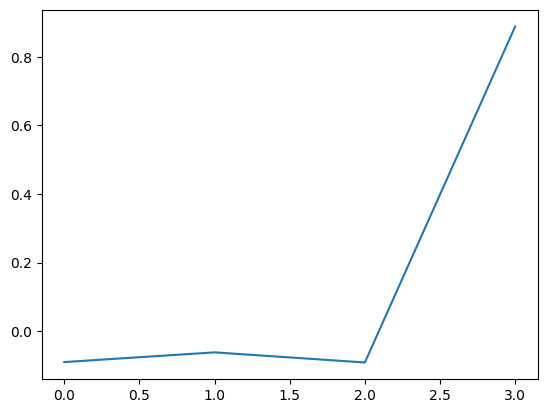

In [516]:
# %pip install scikit-learn
from sklearn.linear_model import LinearRegression, ElasticNet
import numpy as np
#shotdf[shotdf['h_a']=='h']['IsHome'] = 1

all_important_features = ['minute','IsHome','ScoredEarlier','Urgency','WinProb','WinningUnderdog','LosingFavorite','WastedXG','rnd1','rnd2']
important_features = ['Urgency','WinningUnderdog','LosingFavorite']
# important_features = ['rnd2']
X = shotdf[important_features]
y = shotdf['ScaledIsGoal']



model = ElasticNet(alpha=0.01)
model.fit(X, y)
model_numbers = (list(model.coef_) + [model.intercept_])
plt.plot(model_numbers)
model_df = pd.DataFrame([important_features+['bias'],model_numbers])
model_df.to_csv(f'../results/6years_{LEAGUE}_016_076_NoPlayerData2_ElasticNet_001.csv')
print(f'{model_numbers=}')
first_shot = (shotdf.iloc[[0]][important_features] )
print(first_shot)
print(model.predict( first_shot))

In [517]:
aware_coefficient = model.predict(shotdf[important_features])
shotdf['AwareXG'] = shotdf['xG']*aware_coefficient
shotdf[['xG','AwareXG']].head(20)

#plt.plot(sorted(aware_coefficient))

,xG,AwareXG
0,0.540876,0.487475
1,0.493966,0.453145
2,0.509257,0.462482
3,0.599672,0.550115
4,0.355973,0.312898
5,0.479736,0.378779
6,0.456573,0.412171
7,0.345684,0.312066
8,0.490504,0.424974
9,0.460978,0.419756


In [518]:
# mask = (shotdf['ScoredEarlier']==1) & (shotdf['IsGoal']==1)
# shotdf[mask]

# mask2 = (shotdf['ScoredEarlier']==1) & (shotdf['PrevAccumXG']==0)
# shotdf[mask2]
print(len(shotdf.index))
# mask3 = (shotdf['h_team']=='Aston Villa') & (shotdf['a_team']=='Crystal Palace')
#shotdf[mask3].sort_values(by='minute').to_csv('../data/wtf_utakimca_prevaccumxg.csv')

7980


# Zastareo kod

In [519]:
raise Exception

Exception: 

In [ ]:
xg_if_scored_earlier = 0
xg_if_scored_later = 0
total_xg = 0
scored_if_scored_earlier = 0
scored_if_scored_later = 0
total_shots = len(all_player_shot_data)
total_goals = 0
for shot in all_player_shot_data:
    if shot['IsGoal']:
        total_goals+=1
        if shot['ScoredEarlier']==1:
            scored_if_scored_earlier+=1
        if shot['ScoredLater']==1:
            scored_if_scored_later+=1
    if shot['ScoredEarlier']==1:
        xg_if_scored_earlier+=float(shot['xG'])
    if shot['ScoredLater']==1:
        xg_if_scored_later+=float(shot['xG'])
    total_xg += float(shot['xG'])

print(scored_if_scored_earlier, scored_if_scored_later)
print(xg_if_scored_earlier, xg_if_scored_later)
ratio_if_scored_earlier = scored_if_scored_earlier / xg_if_scored_earlier
ratio_if_scored_later = scored_if_scored_later / xg_if_scored_later
ratio_total = total_goals / total_xg
print(f'{ratio_if_scored_earlier=} {ratio_if_scored_later=} {ratio_total=}')

NameError: name 'all_player_shot_data' is not defined

In [ ]:
# print([ lis['id'] for lis in (match_dic[('2015-02-07 15:00:00', 'Leicester', 'Crystal Palace')]) ])
# print([ lis['id'] for lis in (match_dic[('2014-10-04 15:00:00', 'Leicester', 'Burnley')]) ] )

# 'h_team': 'Leicester', 'a_team': 'Burnley', 'h_goals': '2', 'a_goals': '2', 'date': '2014-10-04 15:00:00'


In [ ]:
from functools import reduce
def get_xg_and_goals_for_condition_combination(shot_data, condition_dic):
    keys = list(condition_dic.keys())
    vals = list(condition_dic.values())

    conditional_xg = 0
    conditional_goals = 0

    for shot in shot_data:
        # if len(args)==0 or reduce((lambda x, y: x and y), [shot[arg] for arg in args]):
        if vals == [shot[arg] for arg in keys]:
            conditional_xg += float(shot['xG'])
            conditional_goals += int(shot['IsGoal'])
    return conditional_xg, conditional_goals
print(get_xg_and_goals_for_condition_combination(all_player_shot_data, {'ScoredEarlier': True}) )

# 'State' nije dobar. otkomentarisi ovo kad iskoristis match data da 

# print(get_xg_and_goals_for_condition_combination(all_player_shot_data, {'ScoredEarlier': True ,'State': 'winning'}))
# print(get_xg_and_goals_for_condition_combination(all_player_shot_data, {'ScoredEarlier': True ,'State': 'tied'}))
# print(get_xg_and_goals_for_condition_combination(all_player_shot_data, {'ScoredEarlier': True ,'State': 'losing'}))
# print(get_xg_and_goals_for_condition_combination(all_player_shot_data, {'State': 'winning'}))
# print(get_xg_and_goals_for_condition_combination(all_player_shot_data, {'State': 'tied'}))
# print(get_xg_and_goals_for_condition_combination(all_player_shot_data, {'State': 'losing'}))

(1016.7205622913316, 931)


In [ ]:
[1,2]==[True,2]

True

In [ ]:
print(all_player_shot_data[0])

{'id': '52025', 'minute': '3', 'result': 'BlockedShot', 'X': '0.7830000305175782', 'Y': '0.5209999847412109', 'xG': '0.051129300147295', 'player': 'Tom Davies', 'h_a': 'h', 'player_id': '1042', 'situation': 'OpenPlay', 'season': '2015', 'shotType': 'RightFoot', 'match_id': '453', 'h_team': 'Everton', 'a_team': 'Norwich', 'h_goals': '3', 'a_goals': '0', 'date': '2016-05-15 18:00:00', 'player_assisted': 'Kieran Dowell', 'lastAction': 'LayOff', 'ScoredEarlier': 0, 'ScoredPenEarlier': 0, 'ScoredLater': 0, 'ScoredPenLater': 0, 'IsGoal': False}


# Treba da se odradi game state, znaci da li je u trenutku suta taj tim gubio, pobedjivao ili su bili izjednaceni.
Treba u recniku match_data napraviti hronoloski sortiranu listu suteva (koristeci id) koji su ispali golovi.  onda kad se to zavrsi da se vratimo u shot data i da napravimo jos jednu kolonu / key. ovo ovako mora zato sto je shot data prvenstveno sortiran po igracu pa tek onda po vremenu. Treba koristiti match_id i shot_id sto vise, i cinjenicu da je 0-10 puta u istoriji (jako retko lupam brojeve) dato vise golova u istom minutu (sto je dovoljno da ne utice na podatke)

In [ ]:
understat.match('22009').get_shot_data()



{'h': [{'id': '549079',
   'minute': '0',
   'result': 'BlockedShot',
   'X': '0.8590000152587891',
   'Y': '0.2879999923706055',
   'xG': '0.038173574954271317',
   'player': 'Reece James',
   'h_a': 'h',
   'player_id': '8067',
   'situation': 'OpenPlay',
   'season': '2023',
   'shotType': 'RightFoot',
   'match_id': '22009',
   'h_team': 'Chelsea',
   'a_team': 'Manchester City',
   'h_goals': '4',
   'a_goals': '4',
   'date': '2023-11-12 16:30:00',
   'player_assisted': 'Cole Palmer',
   'lastAction': 'BallTouch'},
  {'id': '549080',
   'minute': '11',
   'result': 'BlockedShot',
   'X': '0.8909999847412109',
   'Y': '0.3129999923706055',
   'xG': '0.04885943979024887',
   'player': 'Cole Palmer',
   'h_a': 'h',
   'player_id': '8497',
   'situation': 'OpenPlay',
   'season': '2023',
   'shotType': 'LeftFoot',
   'match_id': '22009',
   'h_team': 'Chelsea',
   'a_team': 'Manchester City',
   'h_goals': '4',
   'a_goals': '4',
   'date': '2023-11-12 16:30:00',
   'player_assisted'

In [ ]:

# match_dic = {}
# def create_match_dic(row):
#     match_dic[(row['date'], row['h_team'], row['a_team'])] = match_dic.get((row['date'], row['h_team'], row['a_team']),[]) + [row]

# shotdf.apply( func = create_match_dic, axis=0)

# print(shotdf.head(10))

# print(list(match_dic.values())[:10])
# for val in match_dic.values():
#     val.sort(key = lambda row : row['minute'])





In [ ]:
(shotdf[shotdf['date']=='2019-08-24 15:00:00'] ).sort_values(by=['h_team','minute']).to_csv('this_date.csv')